In [1]:
"""
Stochastic Linear
"""
import numpy as np
import pandas as pd
import linkalman
import scipy
from linkalman.models import BaseConstantModel as BCM
from linkalman.core.utils import Constant_M
from scipy.optimize import minimize
import matplotlib.pyplot as plt
%matplotlib inline 



/usr/local/Cellar/python/3.7.2_2/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


# Initialization
A stochastic linear process may be written as:

$\xi_t = \xi_{t-1} + \beta_{t-1} + \varepsilon_{t-1}$

$\beta_{t} = \beta_{t-1} + \delta_{t-1}$

$y_t = \xi_t + \gamma_{t}$

Here $\beta_{t}$ is the stochastic increment.

In [2]:
def my_f(theta):
    sig1 = np.exp(theta[0])
    sig2 = np.exp(theta[1])
    sig3 = np.exp(theta[2])

    F = np.array([[1, 1], [0, 1]])
    Q = np.array([[sig1, 0], [0, sig2]]) 
    R = np.array([[sig3]])
    H = np.array([[1, 0]])
    # Collect system matrices
    M = {'F': F, 'Q': Q, 'H': H, 'R': R}

    return M


In [3]:
def my_solver(param, obj_func, verbose=False, **kwargs):
    """
    Simple solver for LLY
    """
    obj_ = lambda x: -obj_func(x)
    def disp_f(x):
        print('theta is {}. Function value is: {}.'.format(x, obj_func(x)))
    callbackf = None
    if verbose:
        callbackf = disp_f
    res = minimize(obj_, param, callback=callbackf, **kwargs)
    theta_opt = np.array(res.x)
    fval_opt = res.fun
    return theta_opt, fval_opt

In [4]:
# Initialize the model
x = 1  # used to calculate stationary mean
model = BCM()
model.set_f(my_f, is_warning=False)
model.set_solver(my_solver, method='nelder-mead', 
        options={'xatol': 1e-7, 'disp': True, 'maxiter': 10000}, verbose=True) 

# Generate Synthetic Data

In [5]:
# Some initial parameters
theta = np.array([0.1, -0.1, 0.2])  
T = 100  # Make it shorter so the result is more visible
train_split_ratio = 0.7
forecast_cutoff_ratio = 0.8  
missing_range = [0.3, 0.5]

# Split train data
train_split_t = np.floor(T * train_split_ratio).astype(int)

# Generate missing data for forcasting
forecast_t = np.floor(T * forecast_cutoff_ratio).astype(int)

x_col = ['const']
Xt = pd.DataFrame({x_col[0]: x * np.ones(T)})  

# Build simulated data
df, y_col, xi_col = model.simulated_data(input_theta=theta, Xt=Xt)

# Store fully visible y for comparison later
df['y_0_vis'] = df.y_0.copy()  

# Insert some missingness
missing_start_t = np.floor(T * missing_range[0]).astype(int)
missing_end_t = np.floor(T * missing_range[1]).astype(int)
is_missing = (df.index >= missing_start_t) & (df.index < missing_end_t)
df.loc[is_missing, ['y_0']] = np.nan

# Splits models into three groups
is_train = df.index < train_split_t
is_test = (~is_train) & (df.index < forecast_t)
is_forecast = ~(is_train | is_test)

# Create a training and test data
df_train = df.loc[is_train].copy()

# Build two kinds of test data (full data vs. test data only)
df_test = df.copy()  
df_test_only = df.loc[is_test | is_forecast].copy()  

# Create an offset
df_test.loc[is_forecast, ['y_0']] = np.nan
df_test_only.loc[df_test_only.index >= forecast_t, ['y_0']] = np.nan

# Fit and Predict

In [6]:
# Fit data using LLY:
theta_init = np.random.rand(len(theta))
model.fit(df_train, theta_init, y_col=y_col, x_col=x_col, 
              method='LLY')

# Make predictions from LLY:
df_LLY = model.predict(df_test)
df_LLY['kf_ub'] = df_LLY.y_0_filtered + 1.96 * np.sqrt(df_LLY.y_0_fvar)
df_LLY['kf_lb'] = df_LLY.y_0_filtered - 1.96 * np.sqrt(df_LLY.y_0_fvar)
df_LLY['ks_ub'] = df_LLY.y_0_smoothed + 1.96 * np.sqrt(df_LLY.y_0_svar)
df_LLY['ks_lb'] = df_LLY.y_0_smoothed - 1.96 * np.sqrt(df_LLY.y_0_svar)

# Make predictions using true theta:
df_true = model.predict(df_test, theta=theta)
df_true['kf_ub'] = df_true.y_0_filtered + 1.96 * np.sqrt(df_true.y_0_fvar)
df_true['kf_lb'] = df_true.y_0_filtered - 1.96 * np.sqrt(df_true.y_0_fvar)
df_true['ks_ub'] = df_true.y_0_smoothed + 1.96 * np.sqrt(df_true.y_0_svar)
df_true['ks_lb'] = df_true.y_0_smoothed - 1.96 * np.sqrt(df_true.y_0_svar)

theta is [1.0264656  0.85557766 0.66452916]. Function value is: -139.07907752221203.
theta is [1.0264656  0.85557766 0.66452916]. Function value is: -139.07907752221203.
theta is [1.01017249 0.79220154 0.64343299]. Function value is: -138.19211185946776.
theta is [1.0427587  0.63376123 0.71726957]. Function value is: -137.64319956571325.
theta is [1.15681044 0.50700898 0.67507724]. Function value is: -137.054907358173.
theta is [1.15681044 0.22181643 0.70672149]. Function value is: -135.46223149370522.
theta is [1.15681044 0.22181643 0.70672149]. Function value is: -135.46223149370522.
theta is [ 1.31793114 -0.07041791  0.7078935 ]. Function value is: -135.44502803926093.
theta is [ 1.31129321 -0.32861693  0.77196333]. Function value is: -135.29103015512453.
theta is [ 1.331207   -0.40959754  0.67468657]. Function value is: -134.43260191758543.
theta is [ 1.331207   -0.40959754  0.67468657]. Function value is: -134.43260191758543.
theta is [ 1.24511504 -0.62124249  0.74331421]. Functio

theta is [-0.88120312 -0.31369392  0.51337262]. Function value is: -127.43201187260246.
theta is [-0.88120312 -0.31369392  0.51337262]. Function value is: -127.43201187260246.
theta is [-0.88120312 -0.31369392  0.51337262]. Function value is: -127.43201187260246.
theta is [-0.88120312 -0.31369392  0.51337262]. Function value is: -127.43201187260246.
theta is [-0.88054646 -0.31370265  0.5132705 ]. Function value is: -127.43201187252279.
theta is [-0.88109241 -0.31369011  0.51333625]. Function value is: -127.43201186684306.
theta is [-0.88103689 -0.31366858  0.51332584]. Function value is: -127.43201186625998.
theta is [-0.88104752 -0.31369052  0.51334175]. Function value is: -127.43201186574836.
theta is [-0.88104752 -0.31369052  0.51334175]. Function value is: -127.43201186574836.
theta is [-0.88104752 -0.31369052  0.51334175]. Function value is: -127.43201186574836.
theta is [-0.88104752 -0.31369052  0.51334175]. Function value is: -127.43201186574836.
theta is [-0.88102205 -0.3136732

# Check Model Performance
In general, if the model is not stationary, it has very large variance and poor predictability. When we have a trend, it is every more difficult to forecast. Therefore, it is advised to convert a non-stationary process to a stationary one (e.g. using first difference) before estimating.

In [7]:
def simple_plot(df, col_est, col_actual, col_ub, col_lb, label_est,
                label_actual, title, figsize=(20, 10)):
    ax = plt.figure(figsize=figsize)
    plt.plot(df.index, df[col_est], 'r', label=label_est)
    plt.scatter(df_LLY.index, df[col_actual], s=20, c='b', 
                marker='o', label=label_actual)
    plt.fill_between(df.index, df[col_ub], df[col_lb], color='g', alpha=0.2)
    ax.legend(loc='right', fontsize=12)
    plt.title(title, fontsize=22)
    plt.show()

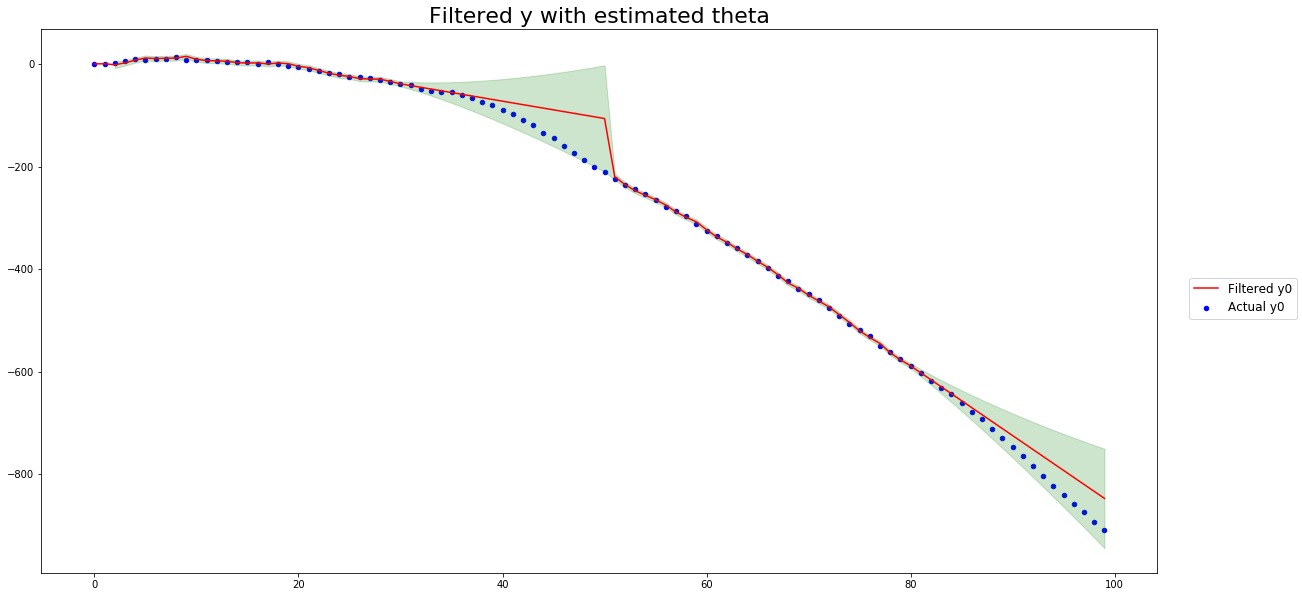

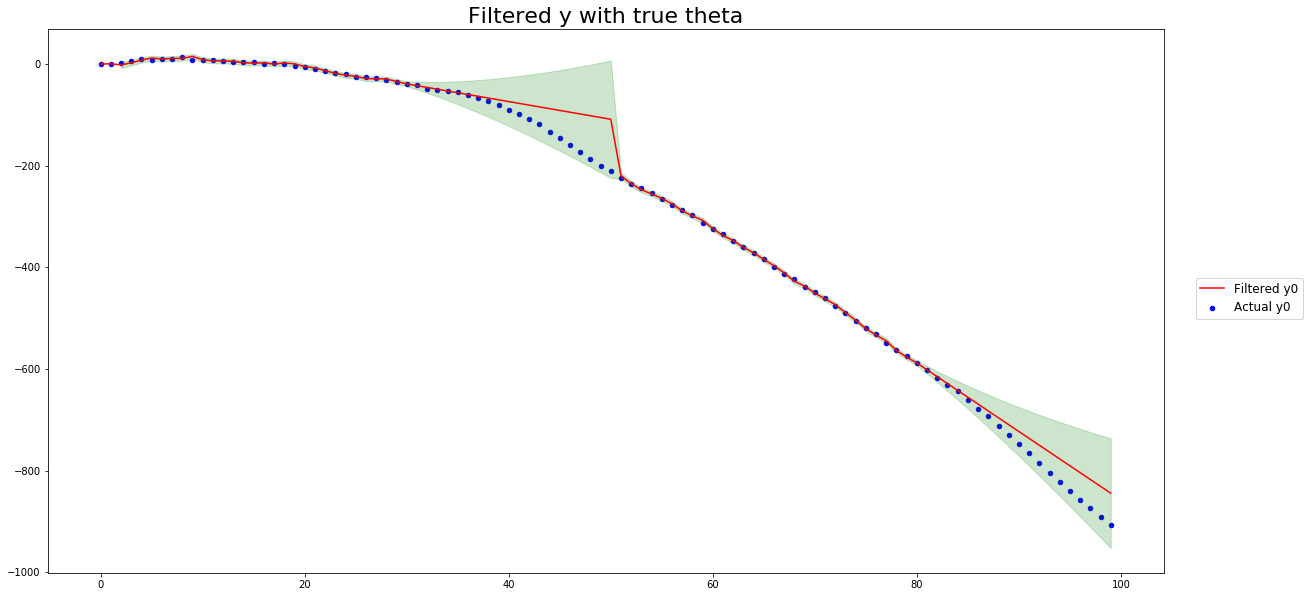

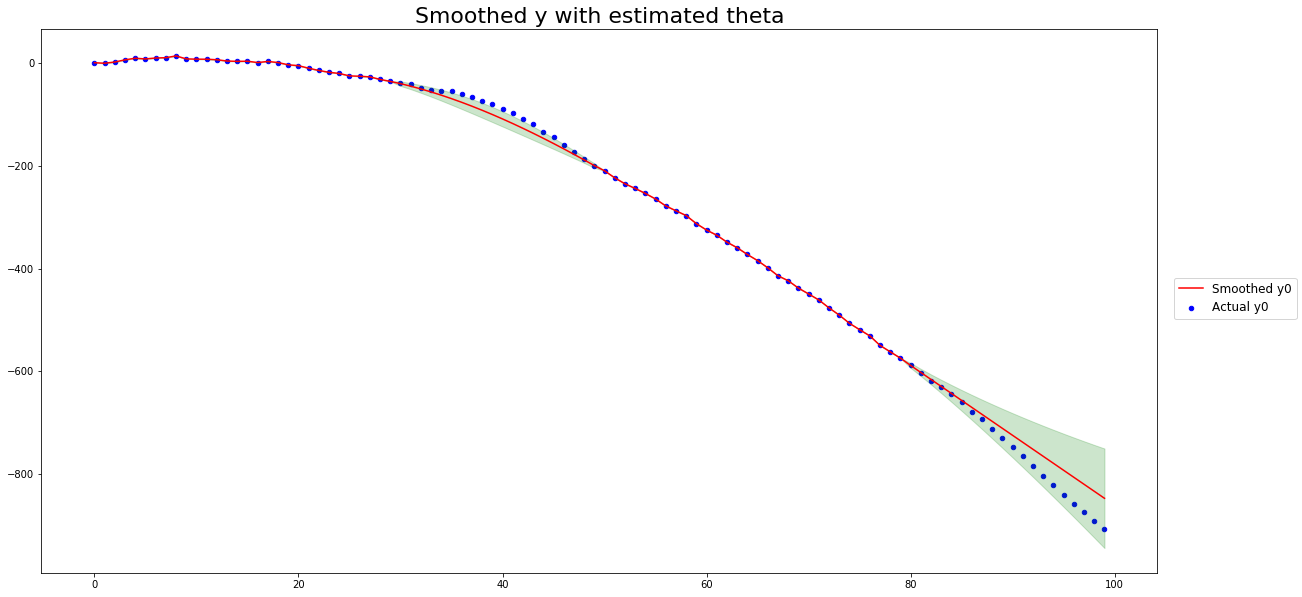

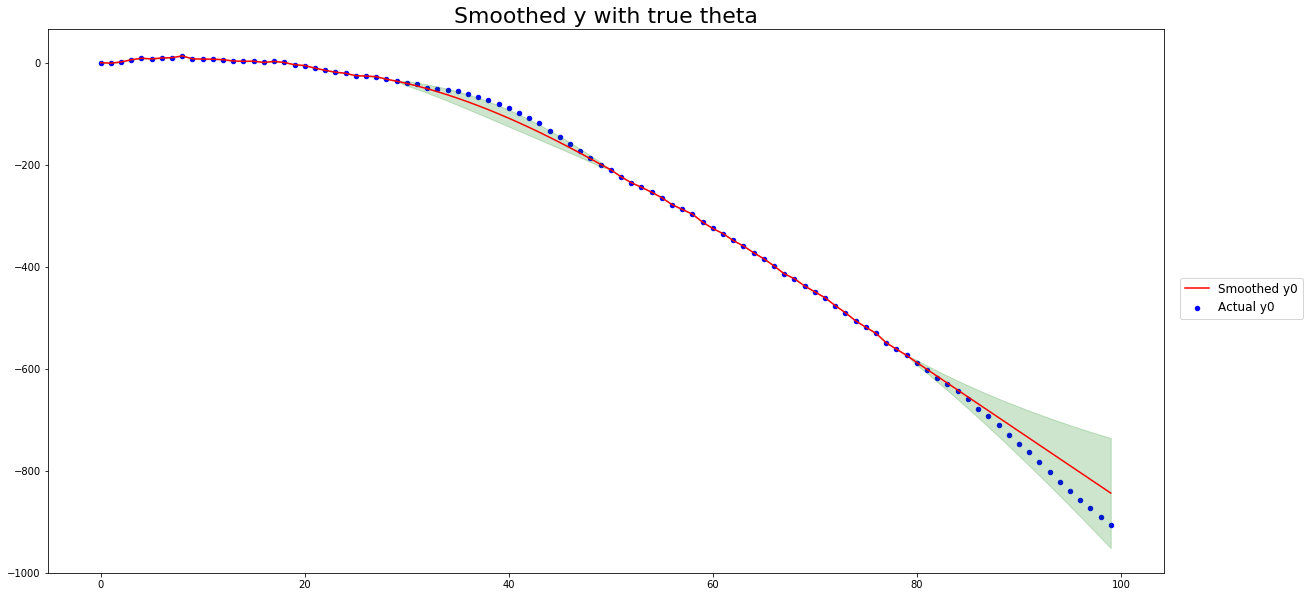

In [8]:
simple_plot(df_LLY, 'y_0_filtered', 'y_0_vis', 'kf_ub', 'kf_lb', 'Filtered y0', 'Actual y0',
           'Filtered y with estimated theta')
simple_plot(df_true, 'y_0_filtered', 'y_0_vis', 'kf_ub', 'kf_lb', 'Filtered y0', 'Actual y0',
           'Filtered y with true theta')
simple_plot(df_LLY, 'y_0_smoothed', 'y_0_vis', 'ks_ub', 'ks_lb', 'Smoothed y0', 'Actual y0',
           'Smoothed y with estimated theta')
simple_plot(df_true, 'y_0_smoothed', 'y_0_vis', 'ks_ub', 'ks_lb', 'Smoothed y0', 'Actual y0',
           'Smoothed y with true theta')

In [9]:
# Build a simple function
def summary_stats(df, col_est, col_true):
    RMSE = np.sqrt((df[col_est] - df[col_true]).var())
    mean_error = (df[col_est] - df[col_true]).mean()
    return {'RMSE': RMSE, 'mean_error': mean_error}

In [10]:
# Compare model performance in training data
print('LLY theta for training data: {}'.format(
    summary_stats(df_LLY[is_train], 'y_0_filtered', 'y_0_vis')))
print('Ture theta for training data: {}'.format(
    summary_stats(df_true[is_train], 'y_0_filtered', 'y_0_vis')))

LLY theta for training data: {'RMSE': 24.198941652043484, 'mean_error': 9.879156622466937}
Ture theta for training data: {'RMSE': 23.60178061752593, 'mean_error': 9.467820983195107}


In [11]:
# Compare model performance in test data
print('LLY theta for test data: {}'.format(
    summary_stats(df_LLY[is_test], 'y_0_filtered', 'y_0_vis')))
print('Ture theta for test data: {}'.format(
    summary_stats(df_true[is_test], 'y_0_filtered', 'y_0_vis')))

LLY theta for test data: {'RMSE': 2.55918556079207, 'mean_error': 0.18238793036937295}
Ture theta for test data: {'RMSE': 2.6195605470316896, 'mean_error': 0.13841406155890468}


In [12]:
# Compare model performance in forecast data
print('LLY theta for forecast data: {}'.format(
    summary_stats(df_LLY[is_forecast], 'y_0_filtered', 'y_0_vis')))
print('Ture theta for forecast data: {}'.format(
    summary_stats(df_true[is_forecast], 'y_0_filtered', 'y_0_vis')))

LLY theta for forecast data: {'RMSE': 21.806924555175925, 'mean_error': 24.747764112870602}
Ture theta for forecast data: {'RMSE': 22.485698814649666, 'mean_error': 26.19185628821585}
